# Homework 5 - Neural Newtorks

__Due Date:__ 2024-11-20 at 8:30 AM PT

__Name:__ Nolan Yager


In [81]:
# Pre-prep

# Import Packages: 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Current WD:
import os
cwd = os.getcwd()
print(cwd)

c:\Users\nyager\Desktop\YagerMLCode\MachineLearning_Fall24\homework


Preparation:
We're using the same [data file](https://github.com/gabehassler/PRGS-Intro-to-ML-2024/blob/main/data/processed/svi_covid.csv) from GitHub as the last assignment in the _data/processed_ folder.

In [82]:
# Loading data
covid_data = pd.read_csv("data/processed/svi_covid.csv")

print(covid_data.head(5))

   Unnamed: 0  fips_code  total_cases_per_100k  total_deaths_per_100k  \
0           1       1001          33888.123075             399.925120   
1           2       1003          30212.064090             313.169394   
2           3       1005          30477.951521             418.056840   
3           4       1007          36623.073120             498.853984   
4           5       1009          31944.750072             441.796300   

   E_TOTPOP  EP_POV150  EP_UNEMP  EP_HBURD  EP_NOHSDP  EP_UNINSUR  ...  \
0     58761       20.2       2.8      19.7        9.6         7.4  ...   
1    233420       18.3       3.4      23.2        8.4         9.3  ...   
2     24877       37.7       5.8      25.1       23.5        10.7  ...   
3     22251       29.0       8.7      23.2       21.1         8.4  ...   
4     59077       22.9       6.0      19.4       18.2        10.2  ...   

   EP_DISABL  EP_SNGPNT  EP_LIMENG  EP_MINRTY  EP_MUNIT  EP_MOBILE  EP_CROWD  \
0       16.4        5.6        0.4  

1. Use a simple neural network to predict the number of per-capita COVID-19 deaths in each county in the US using the SVI variables.
The outcome variable is `total_deaths_per_100k` and the predictor variables are `EP_POV150, EP_UNEMP, EP_HBURD, EP_NOHSDP, EP_UNINSUR, EP_AGE65, EP_AGE17, EP_DISABL, EP_SNGPNT, EP_LIMENG, EP_MINRTY, EP_MUNIT, EP_MOBILE, EP_CROWD, EP_NOVEH, EP_GROUPQ, EP_NOINT`.
The neural network should have one hidden layer with 10 nodes and use the ReLU activation function.
Plot the predicted values against the true values.
What is the mean squared error of the predictions in the test set?

In [83]:
# PREPARATION: 

# Specifying predictor and outcome 
predictor_columns = [
    'EP_POV150', 'EP_UNEMP', 'EP_HBURD', 'EP_NOHSDP', 'EP_UNINSUR',
    'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_LIMENG',
    'EP_MINRTY', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH',
    'EP_GROUPQ', 'EP_NOINT'
]
outcome_column = 'total_deaths_per_100k'

# Data prep (making it a numpy array)
X = covid_data[predictor_columns].values
y = covid_data[outcome_column].values

# Split the data: (note here I am using 80/20, stack overflow noted this is a standard starting point)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize it
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Converting data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [84]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [85]:
# NEURAL NETWORK: 

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(len(predictor_columns), 10) # check it out we got 10 nodes
        self.output = nn.Linear(10, 1) # output layer, 1 node. 
    
    def forward(self, x):
        x = torch.relu(self.hidden(x))  # ReLU activation function
        x = self.output(x)  # Output layer
        return x    

# Creating model
model_simple = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_simple.parameters(), lr=0.01) 

print(model_simple)

SimpleNN(
  (hidden): Linear(in_features=17, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)


In [87]:
# TRAINING AND EVALUATION

# Training model_simple
epochs = 10000
for epoch in range(epochs):
    model_simple.train()  # model in training mode
    optimizer.zero_grad()  
    predictions = model_simple(X_train_tensor) 
    loss = criterion(predictions, y_train_tensor) 
    loss.backward()  
    optimizer.step() 


# Evaluating the model
model_simple.eval()  # model in evaluation mode
with torch.no_grad():  
    test_predictions = model_simple(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item()}')


Test Loss: 18971.412109375


1.b. Plot the predicted values against the true values.

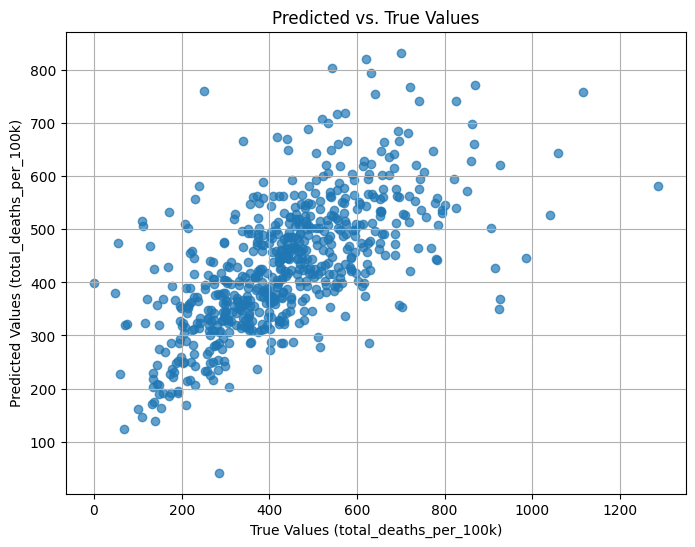

In [89]:
# Switch to evaluation mode
model_simple.eval()

# Get predictions on the test set
with torch.no_grad(): # no gradient
    predictions = model_simple(X_test_tensor)
    predictions = predictions.numpy() # changing these to a numpy array
    y_test_np = y_test_tensor.numpy()  

# Plotting:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_np, predictions, alpha=0.7)
plt.xlabel('True Values (total_deaths_per_100k)')
plt.ylabel('Predicted Values (total_deaths_per_100k)')
plt.title('Predicted vs. True Values')
plt.grid(True)
plt.show()

In [90]:
# MSE, simple model

# Get predictions on the test set
model_simple.eval()
with torch.no_grad():
    predictions = model_simple(X_test_tensor).numpy() 
    y_test_np = y_test_tensor.numpy()  

# Calculate the MSE
mse = mean_squared_error(y_test_np, predictions)
print(f'Mean Squared Error on the test set: {mse}')

Mean Squared Error on the test set: 18971.41015625


2. Repeat the analysis from the previous question, but this time use a more complicated neural network with more hidden layers and/or more nodes in the hidden layers.
You should experiment with different architectures and activation functions to see what works best.
Plot the predicted values against the true values.
What is the mean squared error of the predictions in the test set?

In [119]:
import torch.nn as nn
import torch.optim as optim

# Defining the more complex network here: 
class ComplexNN(nn.Module):
    def __init__(self):
        super(ComplexNN, self).__init__() 
        self.hidden1 = nn.Linear(len(predictor_columns), 12) # hidden layer 1
        self.hidden2 = nn.Linear(12, 6)  # hidden layer 2
        self.output = nn.Linear(6, 1)  # output layer
        
        
    def forward(self, x): # Activating layers
        x = torch.relu(self.hidden1(x))  
        x = torch.relu(self.hidden2(x))  
        x = self.output(x)  
        return x

# Naming the model
model_complex = ComplexNN()

print(model_complex)


ComplexNN(
  (hidden1): Linear(in_features=17, out_features=12, bias=True)
  (hidden2): Linear(in_features=12, out_features=6, bias=True)
  (output): Linear(in_features=6, out_features=1, bias=True)
)


In [ ]:
# Establishing criteria, testing model

# Creating criterion and using Adam optimizer (popular optimizer, same as I used above)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model_complex.parameters(), lr=0.001)

# Training loop (same as before)
epochs = 20000
for epoch in range(epochs):
    model_complex.train()
    optimizer.zero_grad()
    predictions = model_complex(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()
    
     # Print loss every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    
# Evaluate model on test set
model_complex.eval()
with torch.no_grad():
    predictions = model_complex(X_test_tensor)
    mse = mean_squared_error(y_test_tensor.numpy(), predictions.numpy())
    print(f'Mean Squared Error on the test set: {mse}')

Epoch 1000/20000, Loss: 35719.36328125
Epoch 2000/20000, Loss: 25576.76953125
Epoch 3000/20000, Loss: 20409.375
Epoch 4000/20000, Loss: 18230.890625
Epoch 5000/20000, Loss: 17524.32421875
Epoch 6000/20000, Loss: 17065.0390625
Epoch 7000/20000, Loss: 16856.552734375
Epoch 8000/20000, Loss: 16746.396484375
Epoch 9000/20000, Loss: 16610.720703125
Epoch 10000/20000, Loss: 16006.984375
Epoch 11000/20000, Loss: 15576.2890625
Epoch 12000/20000, Loss: 15386.81640625
Epoch 13000/20000, Loss: 15154.740234375
Epoch 14000/20000, Loss: 14996.55859375
Epoch 15000/20000, Loss: 14841.0546875


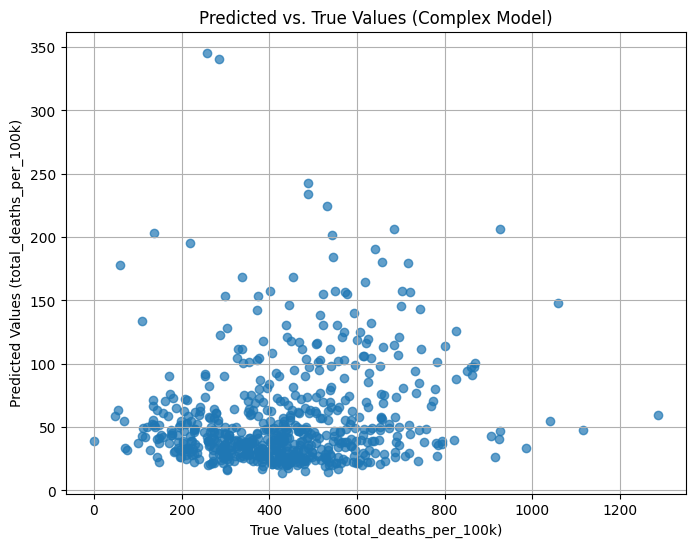

In [ ]:
# PLOTTING COMPLEX MODEL

# Switch the model to evaluation mode
model_complex.eval()

# Get predictions on the test set
with torch.no_grad():
    predictions = model_complex(X_test_tensor)
    predictions = predictions.numpy()  # Convert predictions to a NumPy array
    y_test_np = y_test_tensor.numpy()  # Convert true values to a NumPy array

# Plotting predicted vs. true values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_np, predictions, alpha=0.7)
plt.xlabel('True Values (total_deaths_per_100k)')
plt.ylabel('Predicted Values (total_deaths_per_100k)')
plt.title('Predicted vs. True Values (Complex Model)')
plt.grid(True)
plt.show()


In [ ]:
# MSE, complex

# Get predictions on the test set
model_complex.eval()
with torch.no_grad():
    predictions = model_complex(X_test_tensor).numpy() 
    y_test_np = y_test_tensor.numpy()  

# Calculate the MSE
mse = mean_squared_error(y_test_np, predictions)
print(f'Mean Squared Error on the test set (complex model): {mse}')

Mean Squared Error on the test set (complex model): 176103.5625


Mean Squared Error on the test set (complex model): 176103.5625

3. Compare the predictions of the neural network in Question 2 to the predictions of the regression tree from the previous assignment. Which model would you use to predict the number of per-capita COVID-19 deaths? Why?
Which model would you use to understand the relationship between the SVI variables and the number of per-capita COVID-19 deaths? Why?

Predicting number of per-capita deaths:
I would say that the predictions of the neural network models here are clearly better as compared to the regression tree. With the neural network we've captured nonlinear patterns that the regression tree could not capture. 

Understanding relationships: 
On the other hand, the neural network model here is not really that interpretable. Whereas, with the regression tree, we could readily observe each split in the tree and the covariates associated with each split, making the regression tree fairly easily interpretable. 